In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
from sklearn.pipeline import Pipeline

from components.transformers.rate_transformer import RateTransformer
from components.transformers.log_transformer import LognTransformer


# 1. Data prep
## 1.1. Load full data

In [2]:
X_END = '2022-12-30'
X_TEST_START = '2023-01-02' # check this date - values look shit
X_TEST_END = '2023-02-28'

In [3]:
# load prices from dataset
df = pd.read_excel('data/BazaMSA.xlsx', sheet_name='Ceny')
# Dates as index
df.set_index('Dates', inplace=True)
df.head()

,Zinc,Lead,Nickel,Tin,Aluminium,Copper,Gold,Silver,Platinum,Palladium,Brent Oil,Gas US,SPGSCI
Dates,,,,,,,,,,,,,
2010-01-01,2529.00,2402.00,18452.0,16869.0,2197.00,7342.00,1097.35,16.895,1457.70,407.55,79.36,5.572,524.621
2010-01-04,2542.00,2484.25,18920.0,17369.0,2232.75,7466.25,1117.68,17.440,1516.25,419.88,81.51,5.884,537.943
2010-01-05,2542.25,2493.00,18635.0,17293.0,2268.25,7450.25,1121.35,17.840,1531.50,420.75,81.77,5.637,538.477
2010-01-06,2686.25,2652.75,19083.0,17750.0,2342.75,7630.50,1135.45,18.150,1546.55,425.63,83.18,6.009,547.876
2010-01-07,2575.25,2572.25,18386.0,17404.0,2275.25,7506.50,1131.10,18.265,1553.63,423.38,82.66,5.806,542.586


## 1.2. Data transformations

In [4]:
# Comprehensive scikitlearn `Pipeline` that first creates the rates
# and then performs logn on top
log_rate_pipe = Pipeline(
    steps=[
        ('rates', RateTransformer(period=1)),
        ('logn', LognTransformer())
    ]
)

df_transformed = log_rate_pipe.fit_transform(X=df)

f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Apart from the obvious first row, there are 2 obs where `log` couldn't be applied (in Excel it is similar).

In [5]:
df_transformed[df_transformed.isna().any(axis=1)]

,Zinc,Lead,Nickel,Tin,Aluminium,Copper,Gold,Silver,Platinum,Palladium,Brent Oil,Gas US,SPGSCI
Dates,,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-20,-0.006436,0.008522,0.038512,0.009104,-0.003681,-0.006713,0.006964,0.009129,0.007044,0.007336,NaN,0.093078,-0.044903
2020-04-21,-0.017455,-0.015625,-0.025983,-0.029726,-0.009160,-0.031253,-0.012733,-0.030950,-0.040349,-0.100076,NaN,-0.055021,-0.125228


In [6]:
# Drop all the `na` values
df_transformed.dropna(inplace=True)

# Select dataset to build and test
X = df_transformed.loc[:X_END]
X_test = df_transformed.loc[X_TEST_START:X_TEST_END]

# 2. Kernel density estimation

In [7]:
# Helper dict for positioning on the charts
location_array = []
for row in range(0,7):
    for col in range(0,2):
        location_array.append((row,col))
var_location_dict = {}
for var, idx in zip(X.columns, location_array):
    var_location_dict[var] = idx

## 2.1. Gaussian kernel

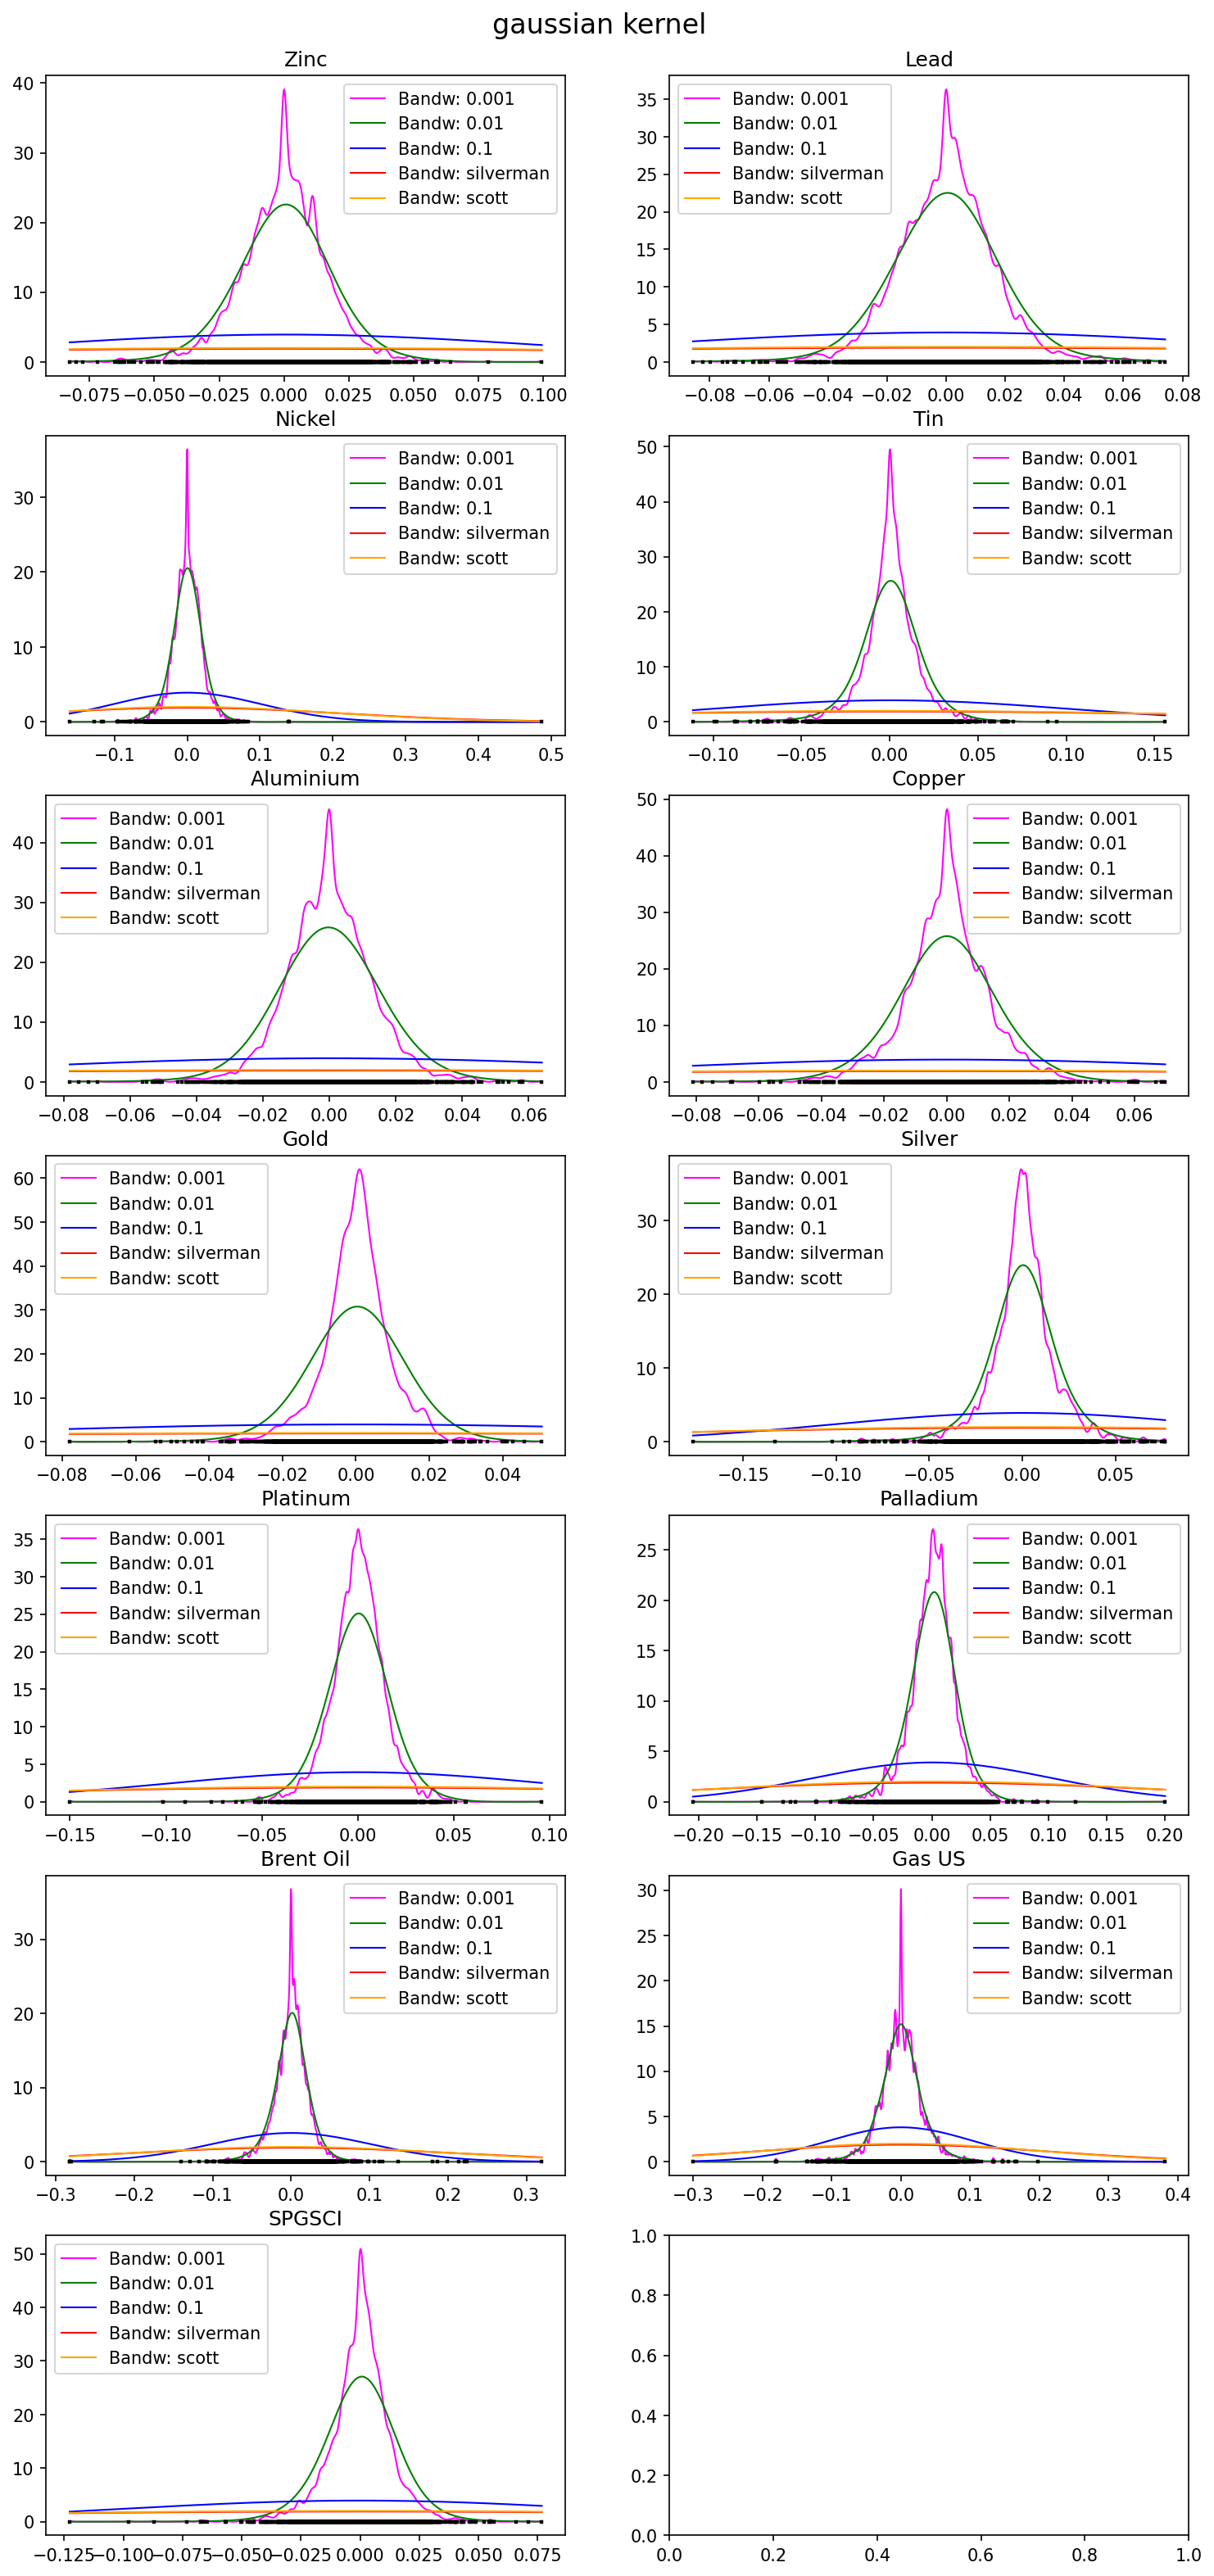

In [8]:
KERNEL = 'gaussian'
BANDWITH = [0.001, 0.01, 0.1, 'silverman', 'scott']
COLOR = ['magenta', 'green', 'blue', 'red', 'orange']

fig, axs = plt.subplots(7, 2)
fig.set_figheight(26)
fig.set_figwidth(12)
fig.set_dpi(150)
fig.suptitle(f'{KERNEL} kernel', x=0.5, y=0.90, fontsize=16)
for var in X.columns:
    # KernelDensity requires 2D array, so need to reshape
    dist = X[var].to_numpy().reshape(-1, 1)

    # x-value range for plotting
    x_range = np.linspace(dist.min(), dist.max(), num=1000)

    for bandwidth, color in zip(BANDWITH, COLOR):
        # fitting KDE
        kde = KernelDensity(kernel=KERNEL, bandwidth=bandwidth).fit(dist)
        # compute the log-likelihood of each sample
        log_density = kde.score_samples(x_range.reshape(-1,1))

        # draw KDE curves
        row, col = var_location_dict[var][0], var_location_dict[var][1]
        axs[row, col].set_title(var)
        axs[row, col].plot(
            x_range, np.exp(log_density), color=color, linewidth=1, label=f'Bandw: {bandwidth}')
        axs[row, col].legend()
        axs[row, col].plot(dist, np.zeros_like(dist) , 's', 
        markersize=1, color='black')
        # axs[row, col].set_xlabel('$x$', fontsize=8)
        # axs[row, col].set_ylabel('$f(x)$', fontsize=12, rotation='horizontal', labelpad=8)
plt.show()

## 2.2. Tophat kernel

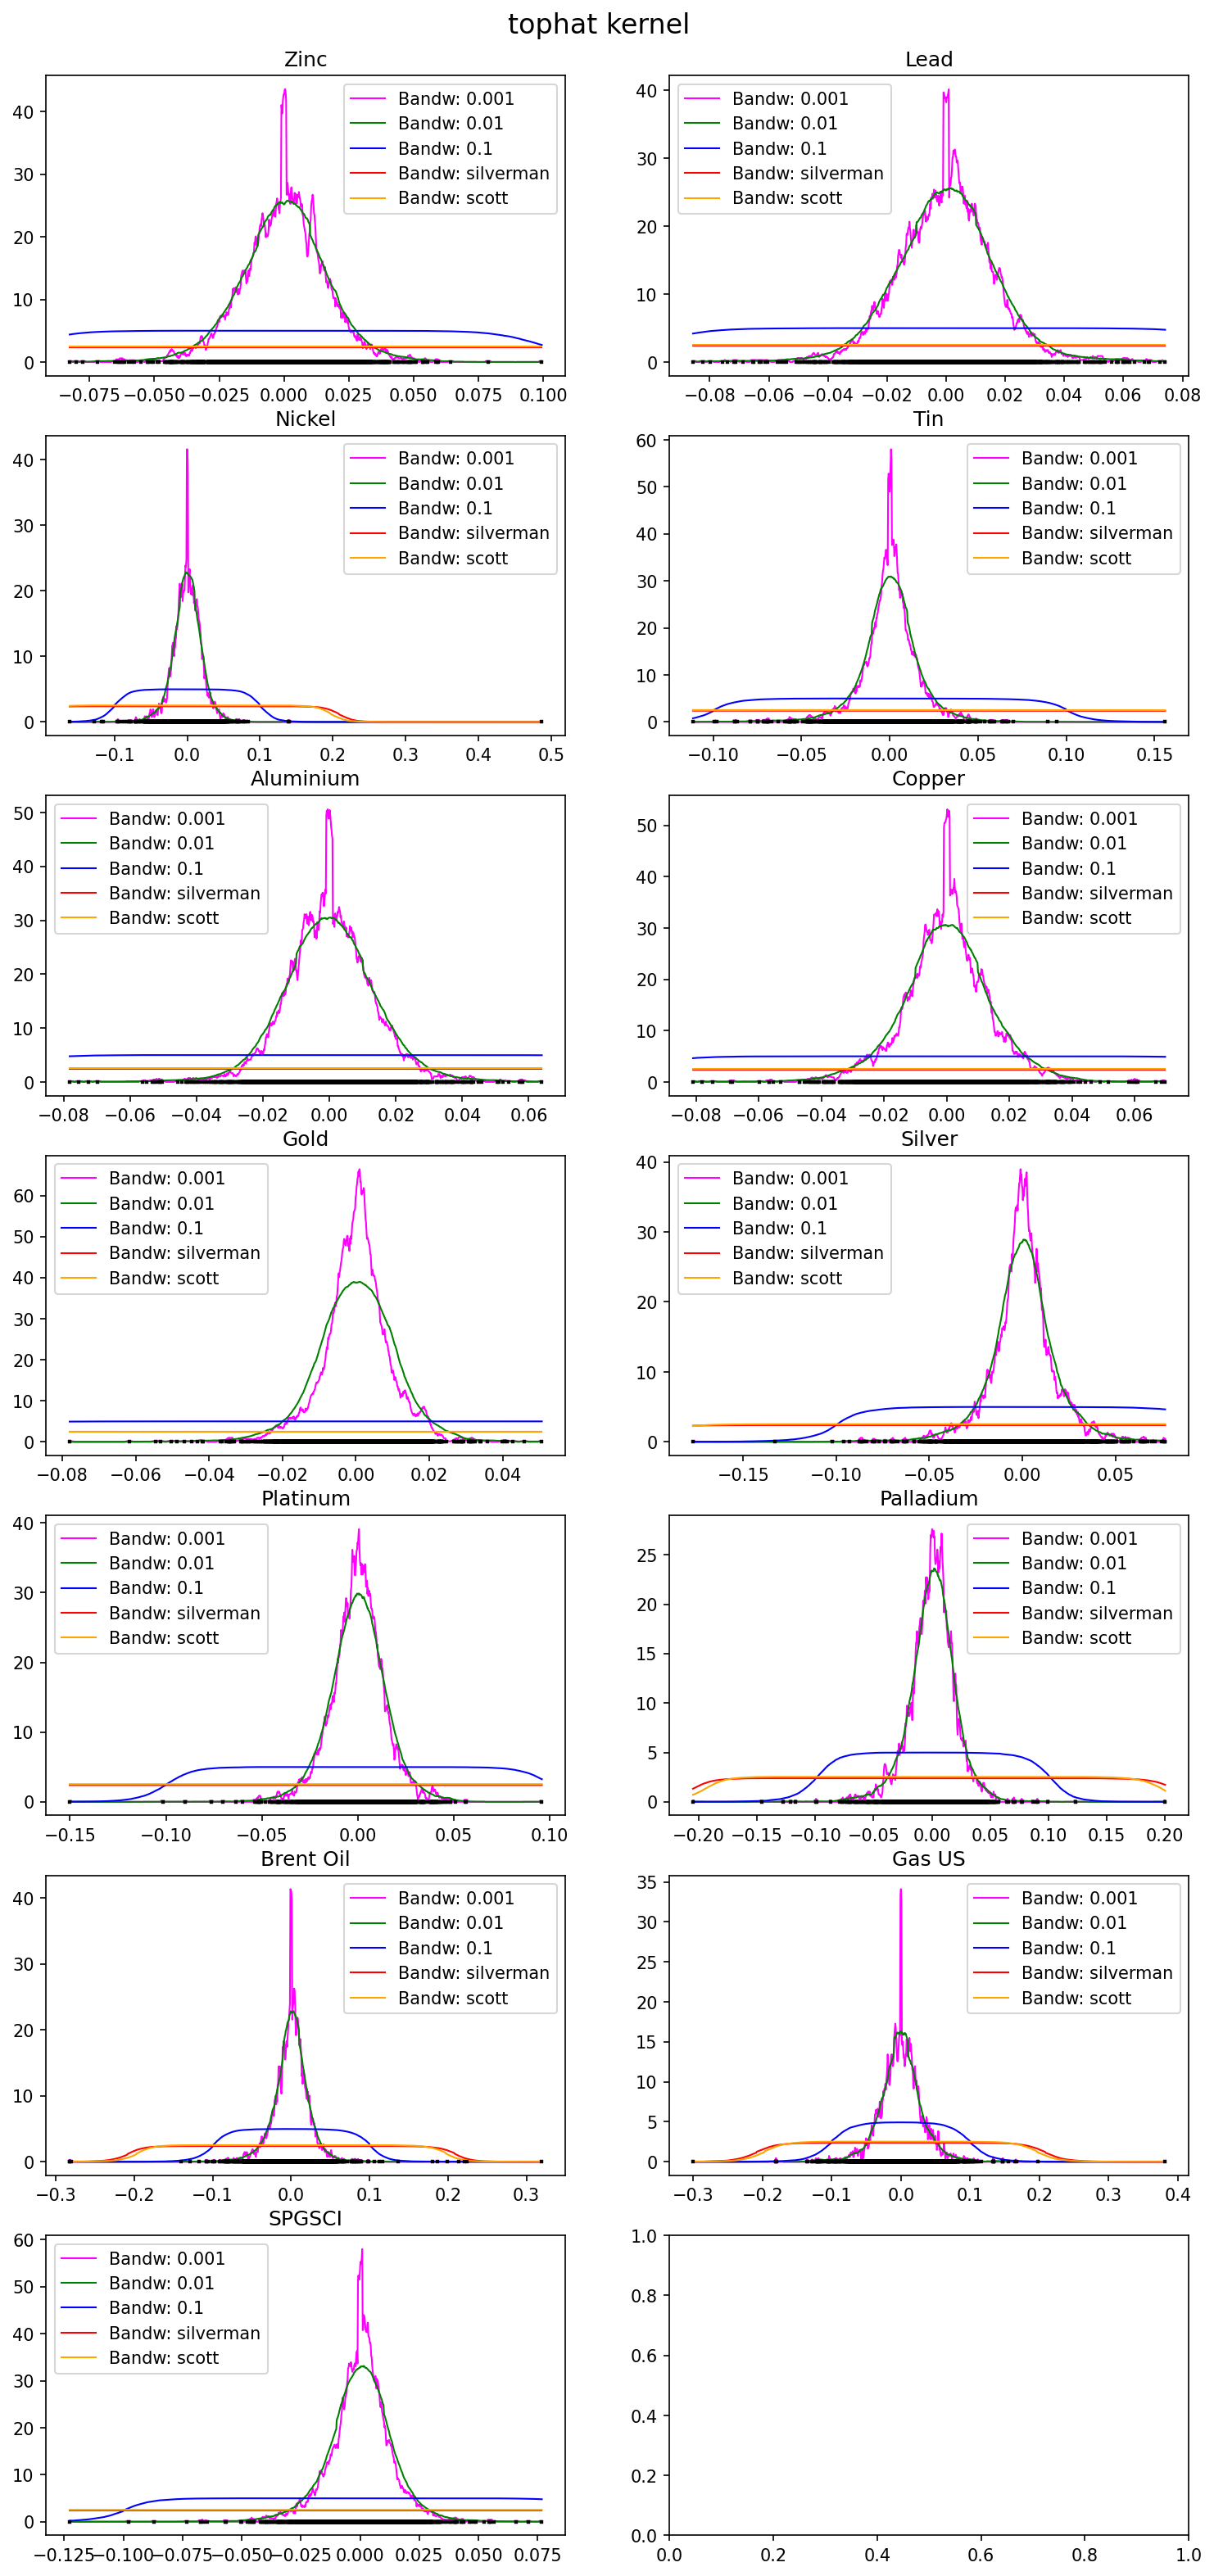

In [9]:
KERNEL = 'tophat'
BANDWITH = [0.001, 0.01, 0.1, 'silverman', 'scott']
COLOR = ['magenta', 'green', 'blue', 'red', 'orange']

fig, axs = plt.subplots(7, 2)
fig.set_figheight(26)
fig.set_figwidth(12)
fig.set_dpi(150)
fig.suptitle(f'{KERNEL} kernel', x=0.5, y=0.90, fontsize=16)
for var in X.columns:
    # KernelDensity requires 2D array, so need to reshape
    dist = X[var].to_numpy().reshape(-1, 1)

    # x-value range for plotting
    x_range = np.linspace(dist.min(), dist.max(), num=1000)

    for bandwidth, color in zip(BANDWITH, COLOR):
        # fitting KDE
        kde = KernelDensity(kernel=KERNEL, bandwidth=bandwidth).fit(dist)
        # compute the log-likelihood of each sample
        log_density = kde.score_samples(x_range.reshape(-1,1))

        # draw KDE curves
        row, col = var_location_dict[var][0], var_location_dict[var][1]
        axs[row, col].set_title(var)
        axs[row, col].plot(
            x_range, np.exp(log_density), color=color, linewidth=1, label=f'Bandw: {bandwidth}')
        axs[row, col].legend()
        axs[row, col].plot(dist, np.zeros_like(dist) , 's', 
        markersize=1, color='black')
        # axs[row, col].set_xlabel('$x$', fontsize=8)
        # axs[row, col].set_ylabel('$f(x)$', fontsize=12, rotation='horizontal', labelpad=8)
plt.show()

## 2.3. Epanechnikov kernel

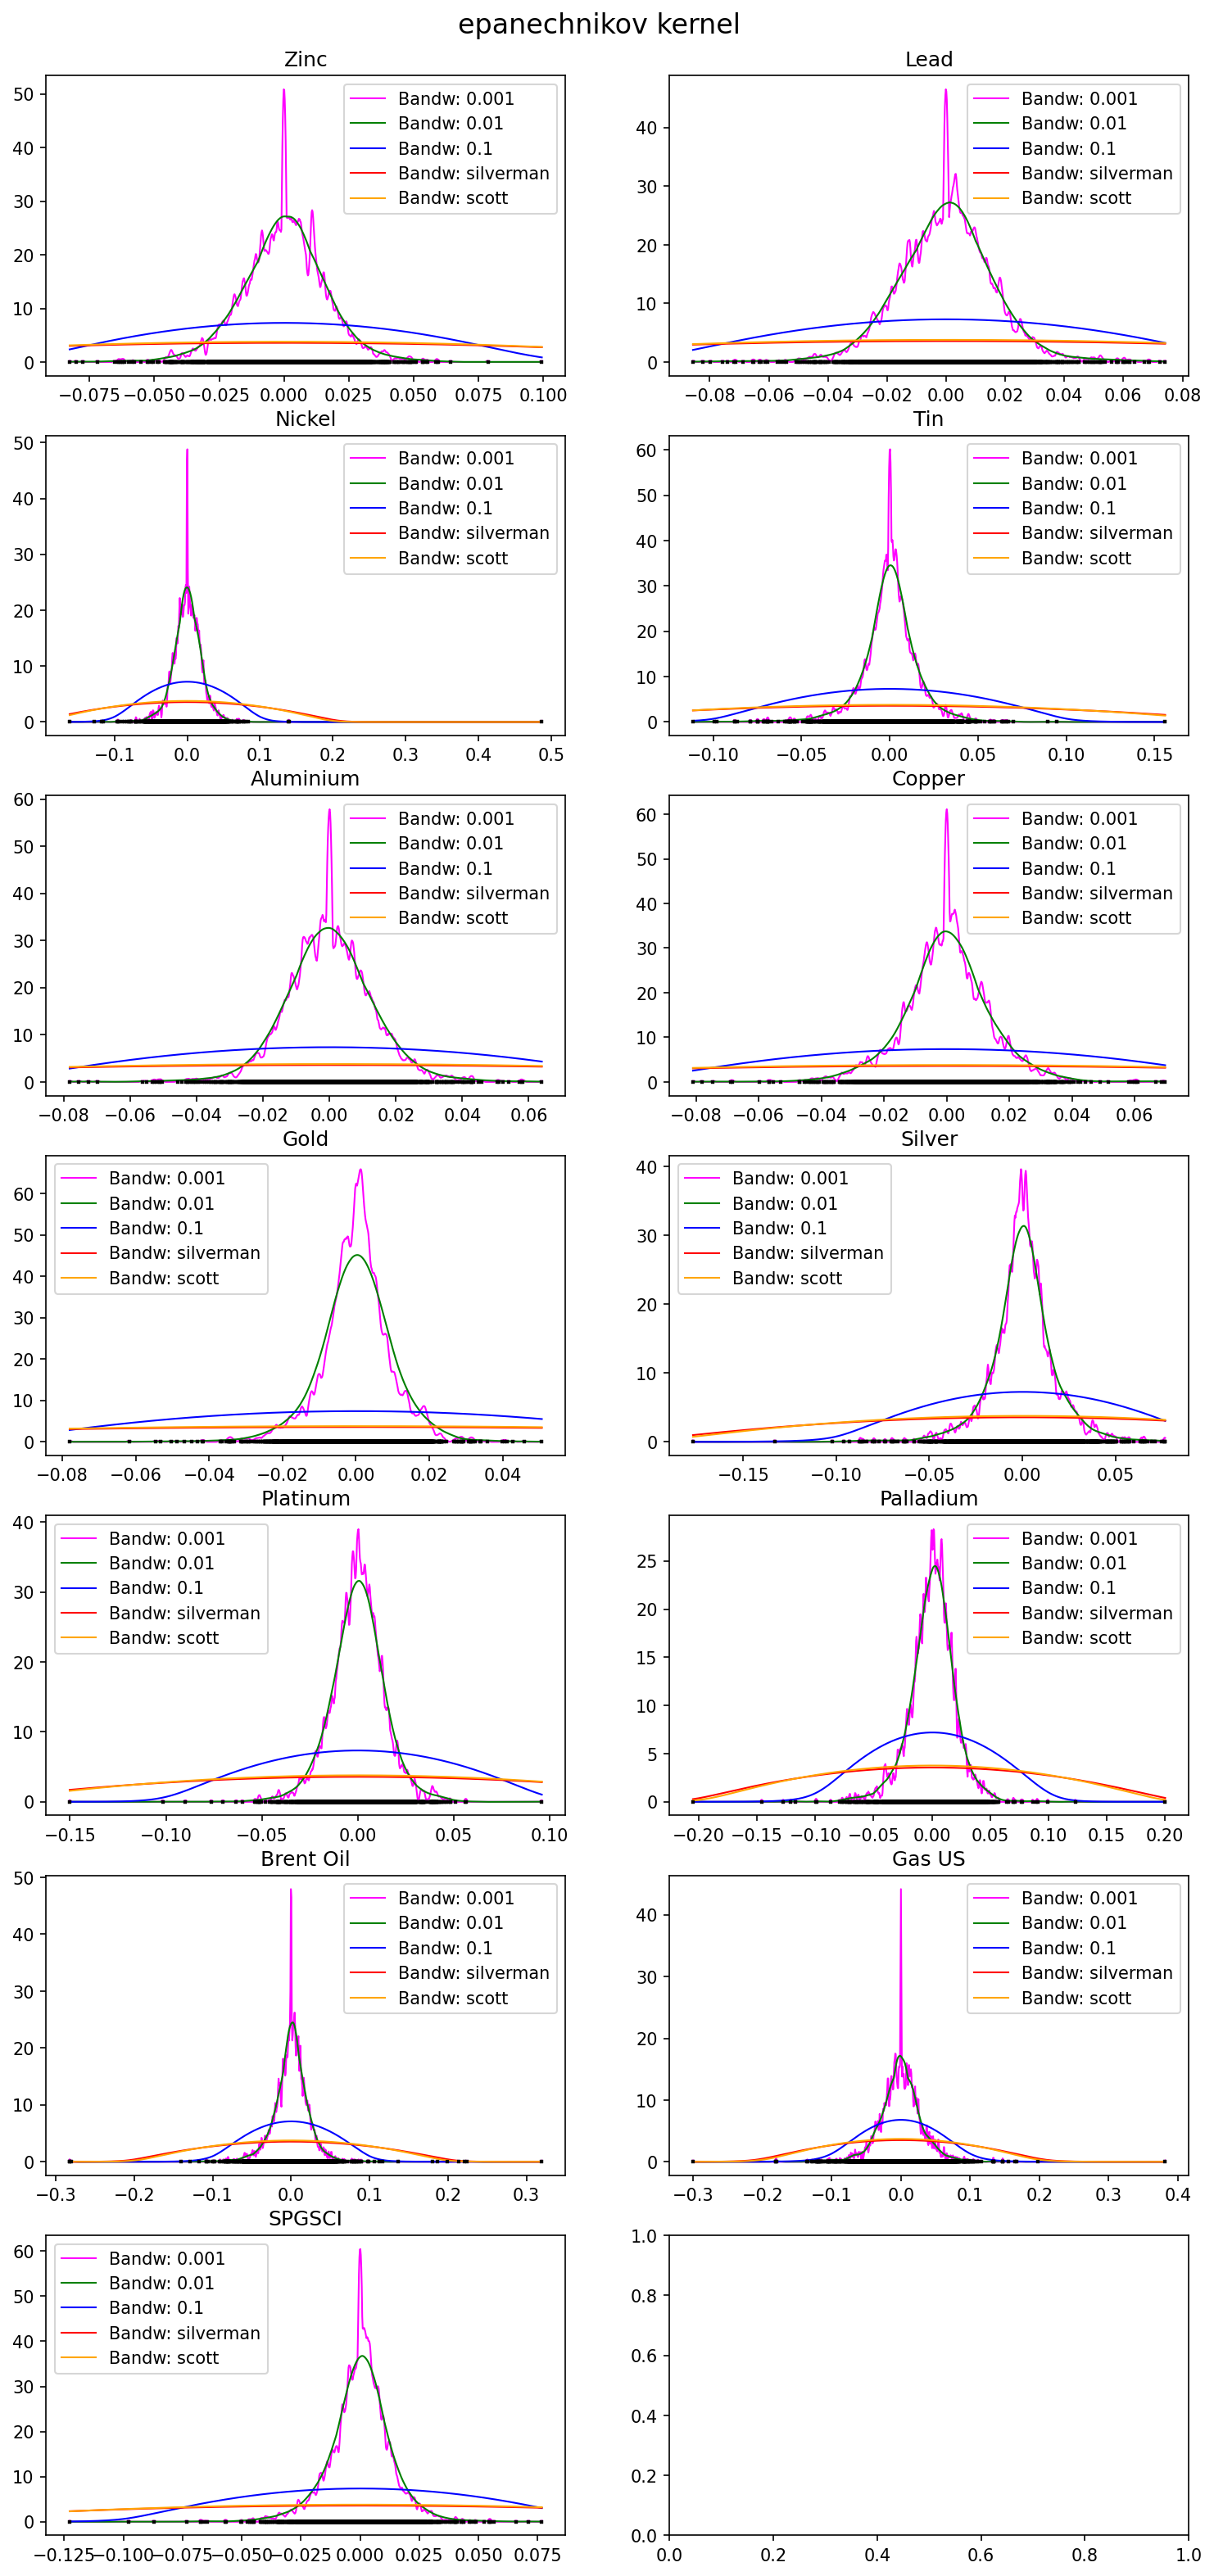

In [10]:
KERNEL = 'epanechnikov'
BANDWITH = [0.001, 0.01, 0.1, 'silverman', 'scott']
COLOR = ['magenta', 'green', 'blue', 'red', 'orange']

fig, axs = plt.subplots(7, 2)
fig.set_figheight(26)
fig.set_figwidth(12)
fig.set_dpi(150)
fig.suptitle(f'{KERNEL} kernel', x=0.5, y=0.90, fontsize=16)
for var in X.columns:
    # KernelDensity requires 2D array, so need to reshape
    dist = X[var].to_numpy().reshape(-1, 1)

    # x-value range for plotting
    x_range = np.linspace(dist.min(), dist.max(), num=1000)

    for bandwidth, color in zip(BANDWITH, COLOR):
        # fitting KDE
        kde = KernelDensity(kernel=KERNEL, bandwidth=bandwidth).fit(dist)
        # compute the log-likelihood of each sample
        log_density = kde.score_samples(x_range.reshape(-1,1))

        # draw KDE curves
        row, col = var_location_dict[var][0], var_location_dict[var][1]
        axs[row, col].set_title(var)
        axs[row, col].plot(
            x_range, np.exp(log_density), color=color, linewidth=1, label=f'Bandw: {bandwidth}')
        axs[row, col].legend()
        axs[row, col].plot(dist, np.zeros_like(dist) , 's', 
        markersize=1, color='black')
        # axs[row, col].set_xlabel('$x$', fontsize=8)
        # axs[row, col].set_ylabel('$f(x)$', fontsize=12, rotation='horizontal', labelpad=8)
plt.show()

## 2.4. Exponential kernel

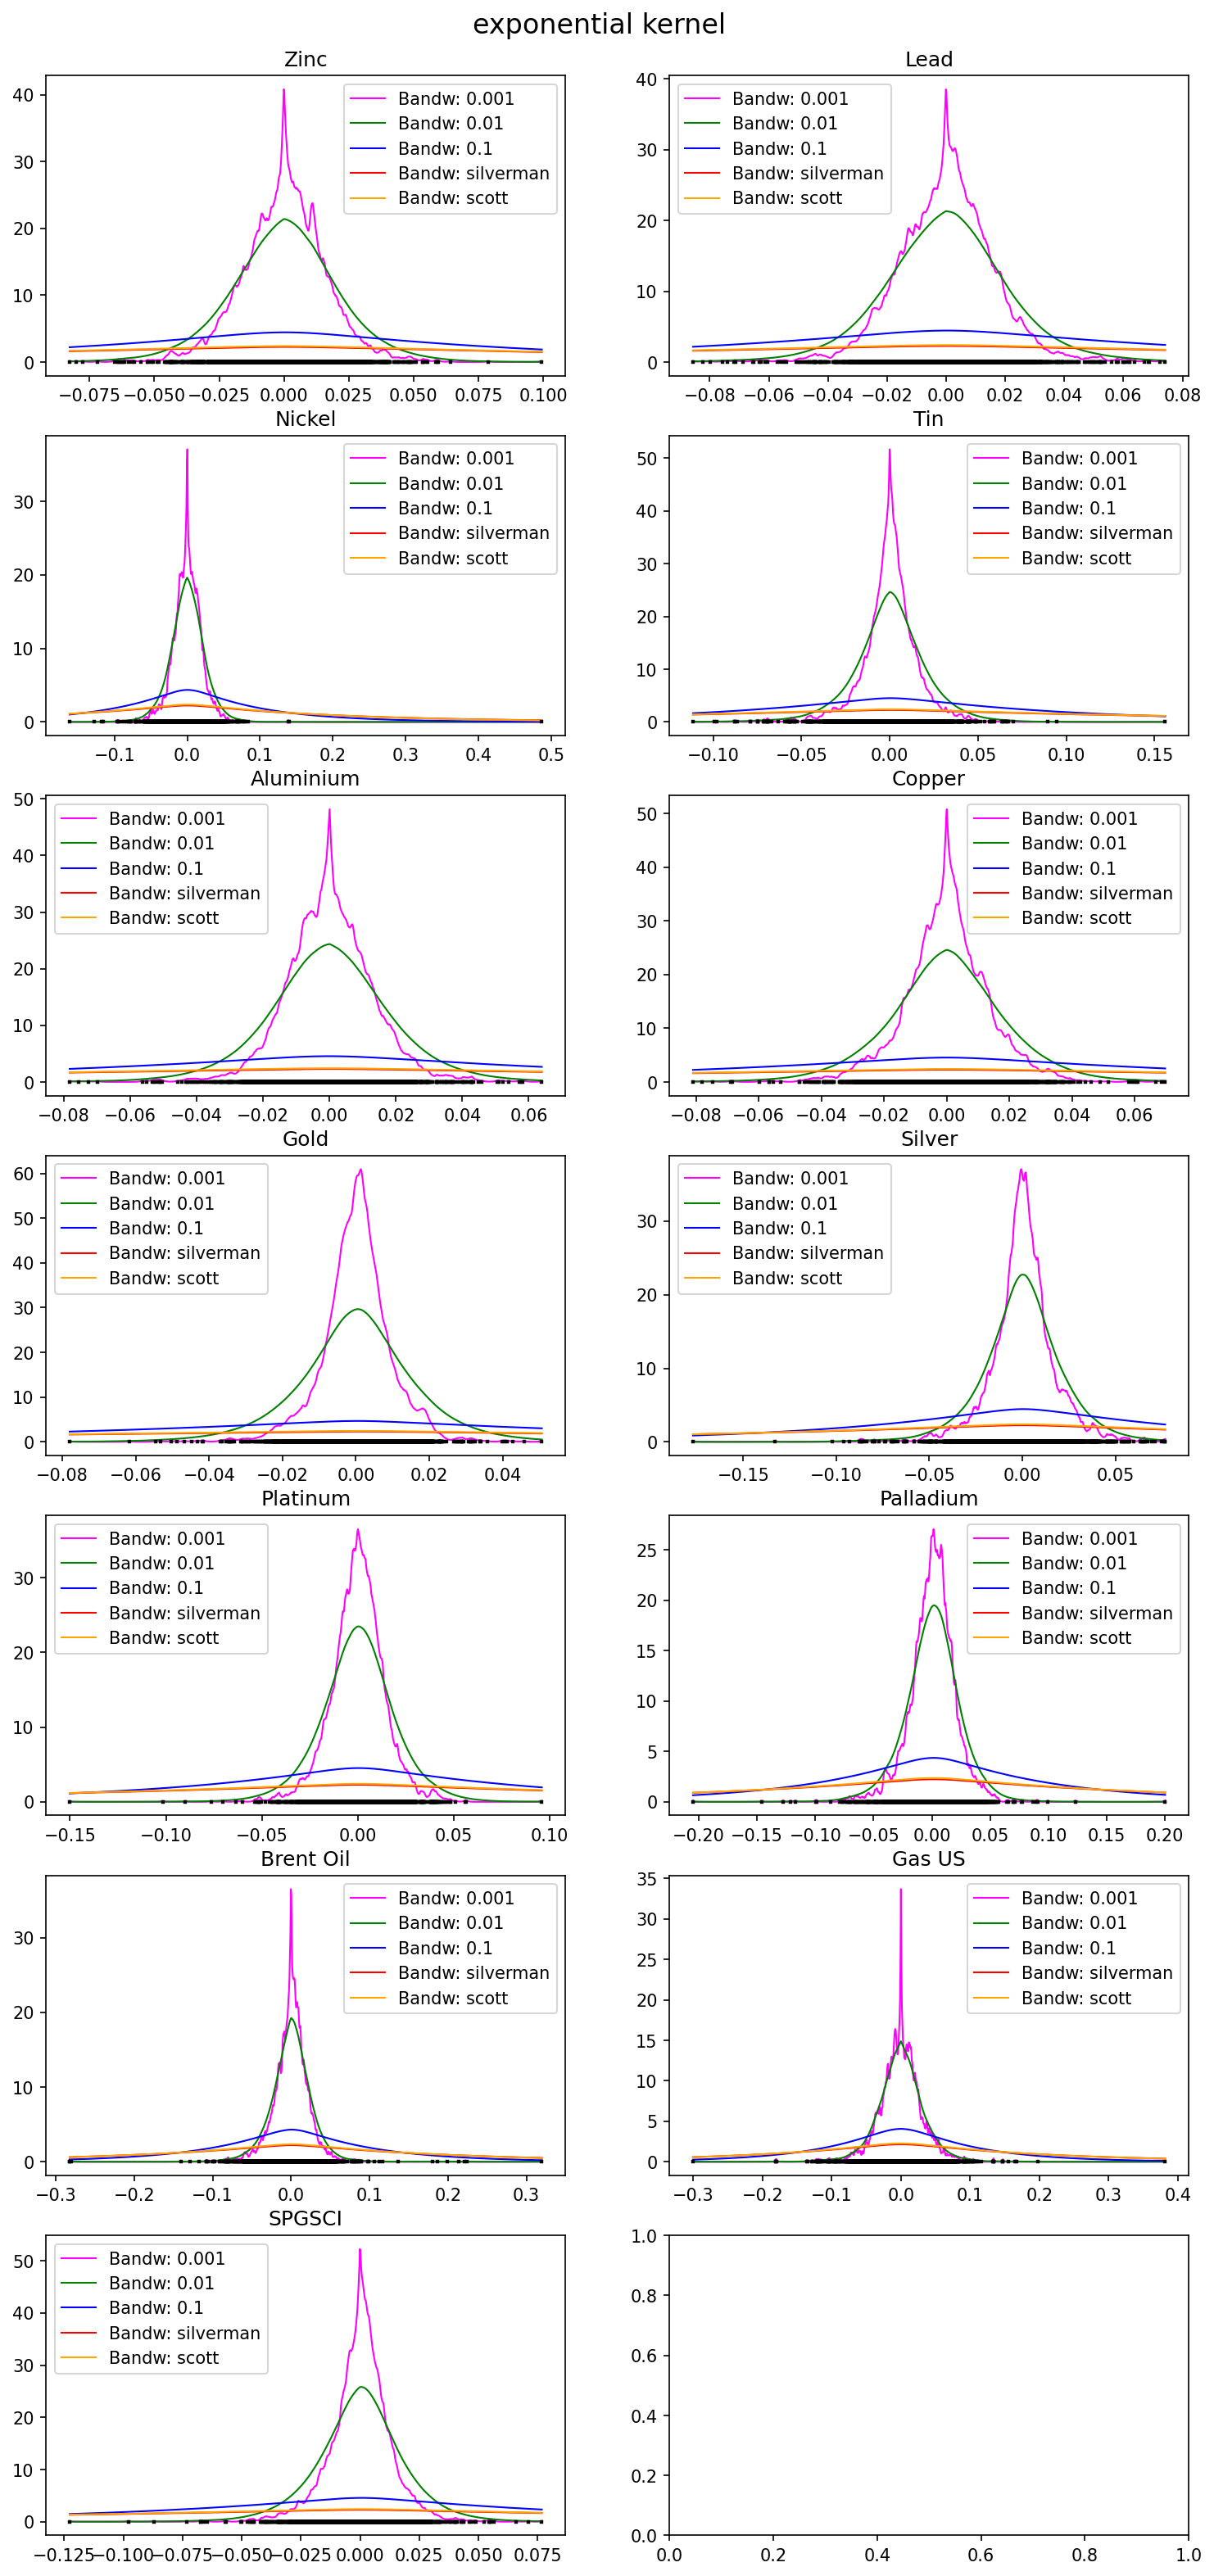

In [11]:
KERNEL = 'exponential'
BANDWITH = [0.001, 0.01, 0.1, 'silverman', 'scott']
COLOR = ['magenta', 'green', 'blue', 'red', 'orange']

fig, axs = plt.subplots(7, 2)
fig.set_figheight(26)
fig.set_figwidth(12)
fig.set_dpi(150)
fig.suptitle(f'{KERNEL} kernel', x=0.5, y=0.90, fontsize=16)
for var in X.columns:
    # KernelDensity requires 2D array, so need to reshape
    dist = X[var].to_numpy().reshape(-1, 1)

    # x-value range for plotting
    x_range = np.linspace(dist.min(), dist.max(), num=1000)

    for bandwidth, color in zip(BANDWITH, COLOR):
        # fitting KDE
        kde = KernelDensity(kernel=KERNEL, bandwidth=bandwidth).fit(dist)
        # compute the log-likelihood of each sample
        log_density = kde.score_samples(x_range.reshape(-1,1))

        # draw KDE curves
        row, col = var_location_dict[var][0], var_location_dict[var][1]
        axs[row, col].set_title(var)
        axs[row, col].plot(
            x_range, np.exp(log_density), color=color, linewidth=1, label=f'Bandw: {bandwidth}')
        axs[row, col].legend()
        axs[row, col].plot(dist, np.zeros_like(dist) , 's', 
        markersize=1, color='black')
        # axs[row, col].set_xlabel('$x$', fontsize=8)
        # axs[row, col].set_ylabel('$f(x)$', fontsize=12, rotation='horizontal', labelpad=8)
plt.show()

## 2.5. Linear kernel

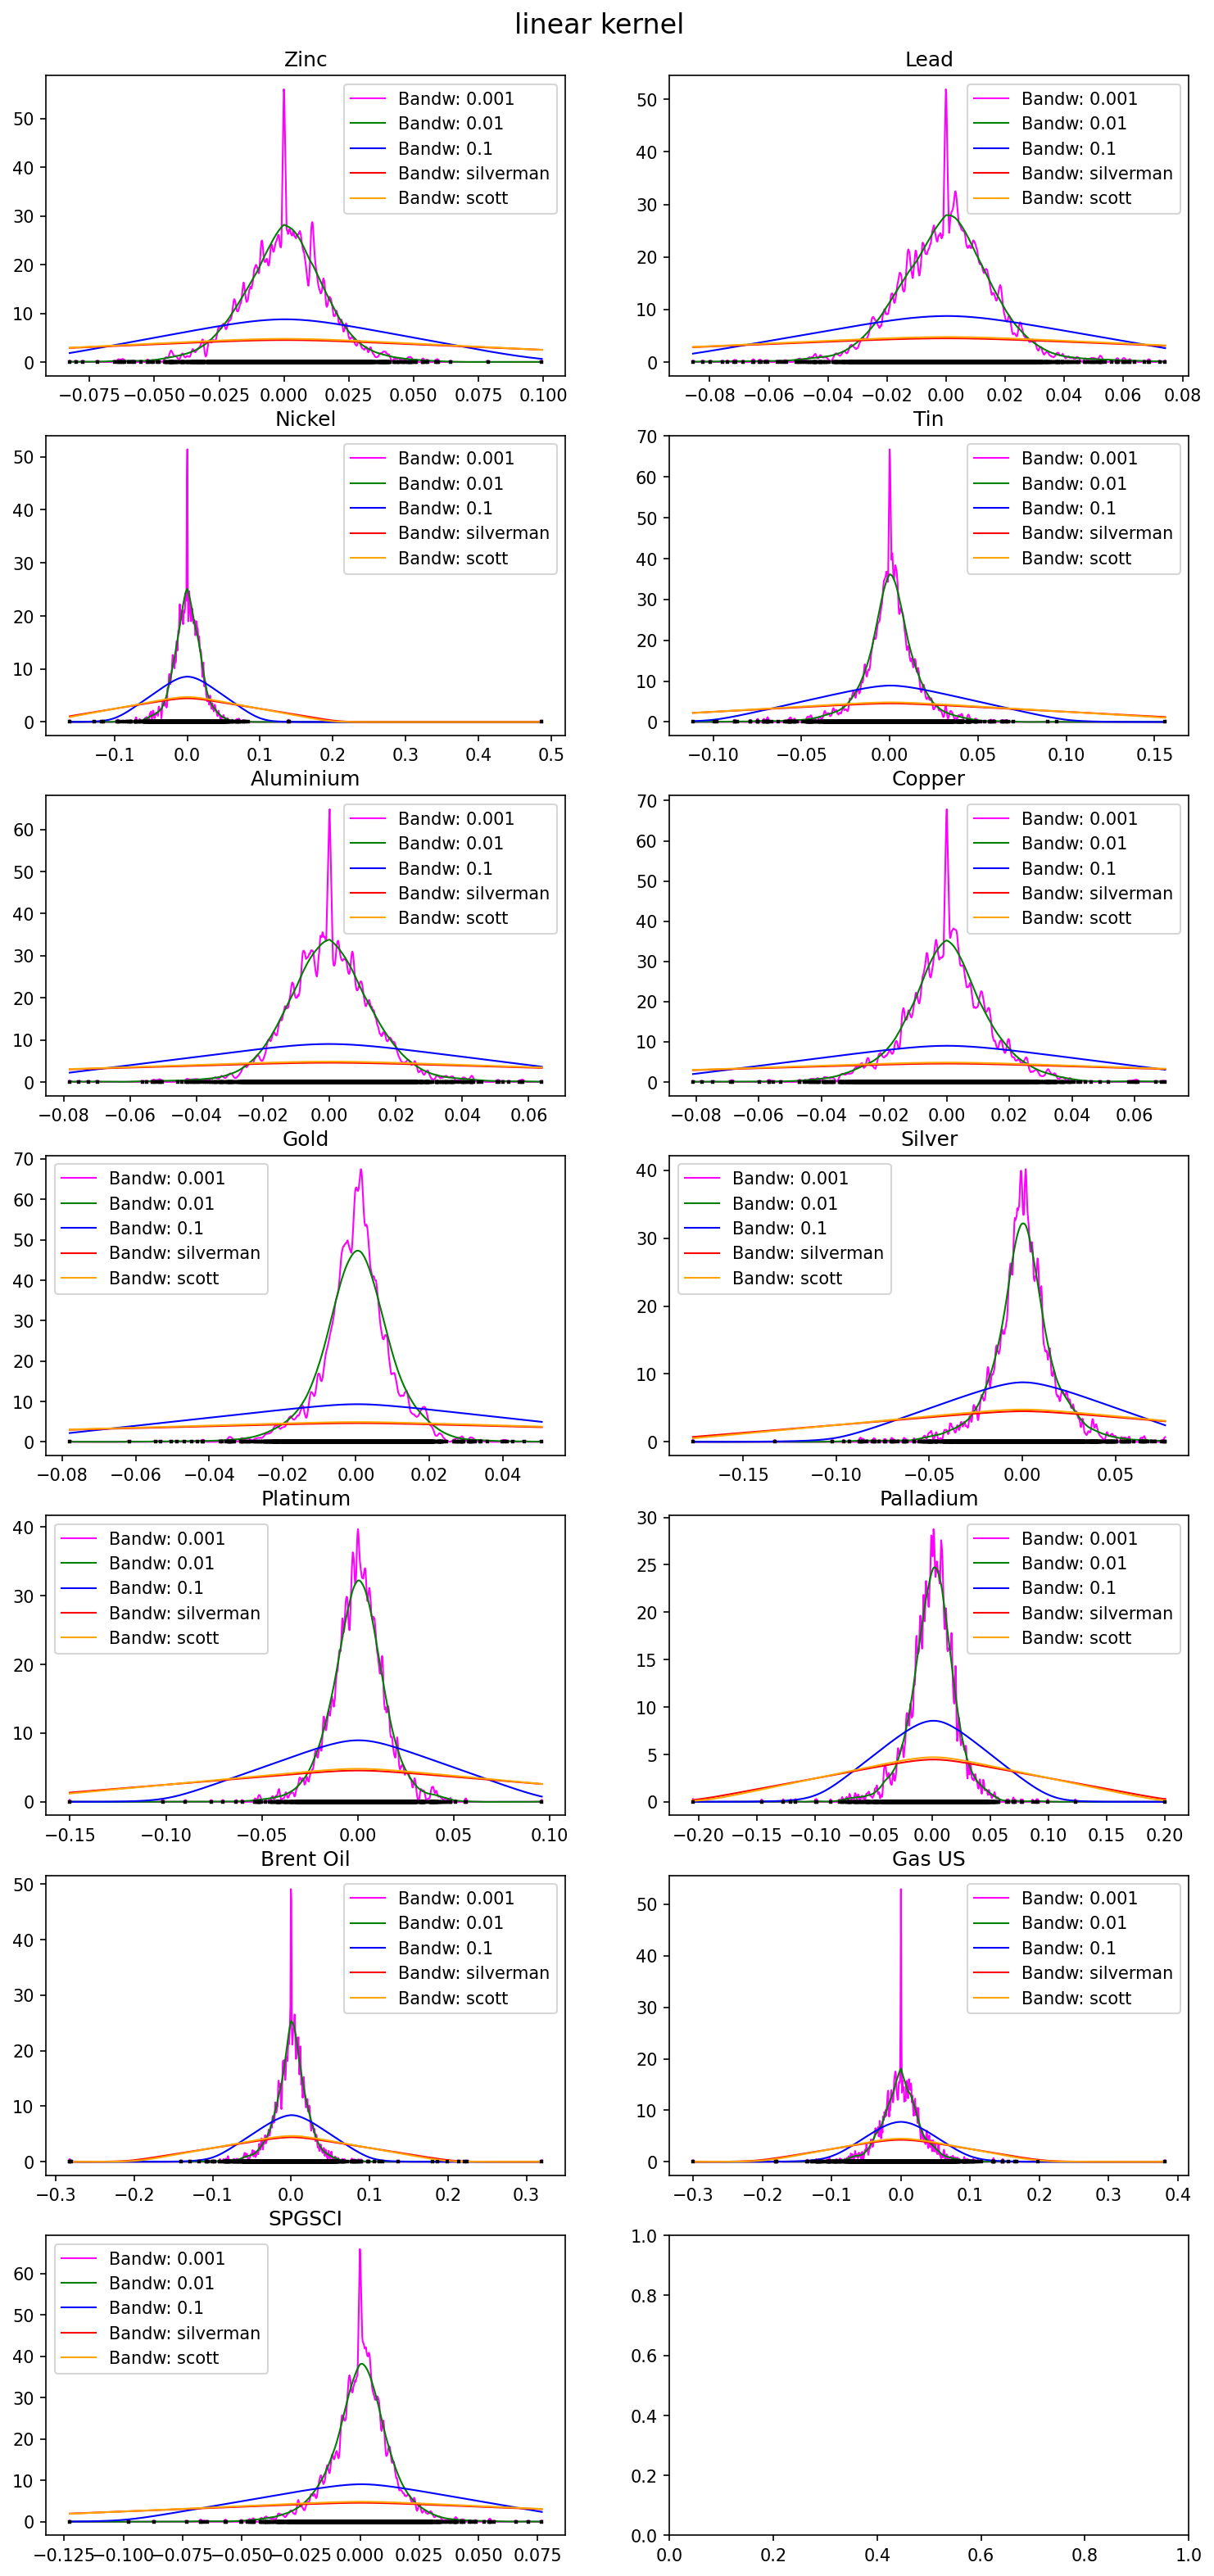

In [12]:
KERNEL = 'linear'
BANDWITH = [0.001, 0.01, 0.1, 'silverman', 'scott']
COLOR = ['magenta', 'green', 'blue', 'red', 'orange']

fig, axs = plt.subplots(7, 2)
fig.set_figheight(26)
fig.set_figwidth(12)
fig.set_dpi(150)
fig.suptitle(f'{KERNEL} kernel', x=0.5, y=0.90, fontsize=16)
for var in X.columns:
    # KernelDensity requires 2D array, so need to reshape
    dist = X[var].to_numpy().reshape(-1, 1)

    # x-value range for plotting
    x_range = np.linspace(dist.min(), dist.max(), num=1000)

    for bandwidth, color in zip(BANDWITH, COLOR):
        # fitting KDE
        kde = KernelDensity(kernel=KERNEL, bandwidth=bandwidth).fit(dist)
        # compute the log-likelihood of each sample
        log_density = kde.score_samples(x_range.reshape(-1,1))

        # draw KDE curves
        row, col = var_location_dict[var][0], var_location_dict[var][1]
        axs[row, col].set_title(var)
        axs[row, col].plot(
            x_range, np.exp(log_density), color=color, linewidth=1, label=f'Bandw: {bandwidth}')
        axs[row, col].legend()
        axs[row, col].plot(dist, np.zeros_like(dist) , 's', 
        markersize=1, color='black')
        # axs[row, col].set_xlabel('$x$', fontsize=8)
        # axs[row, col].set_ylabel('$f(x)$', fontsize=12, rotation='horizontal', labelpad=8)
plt.show()

## 2.6. Cosine kernel

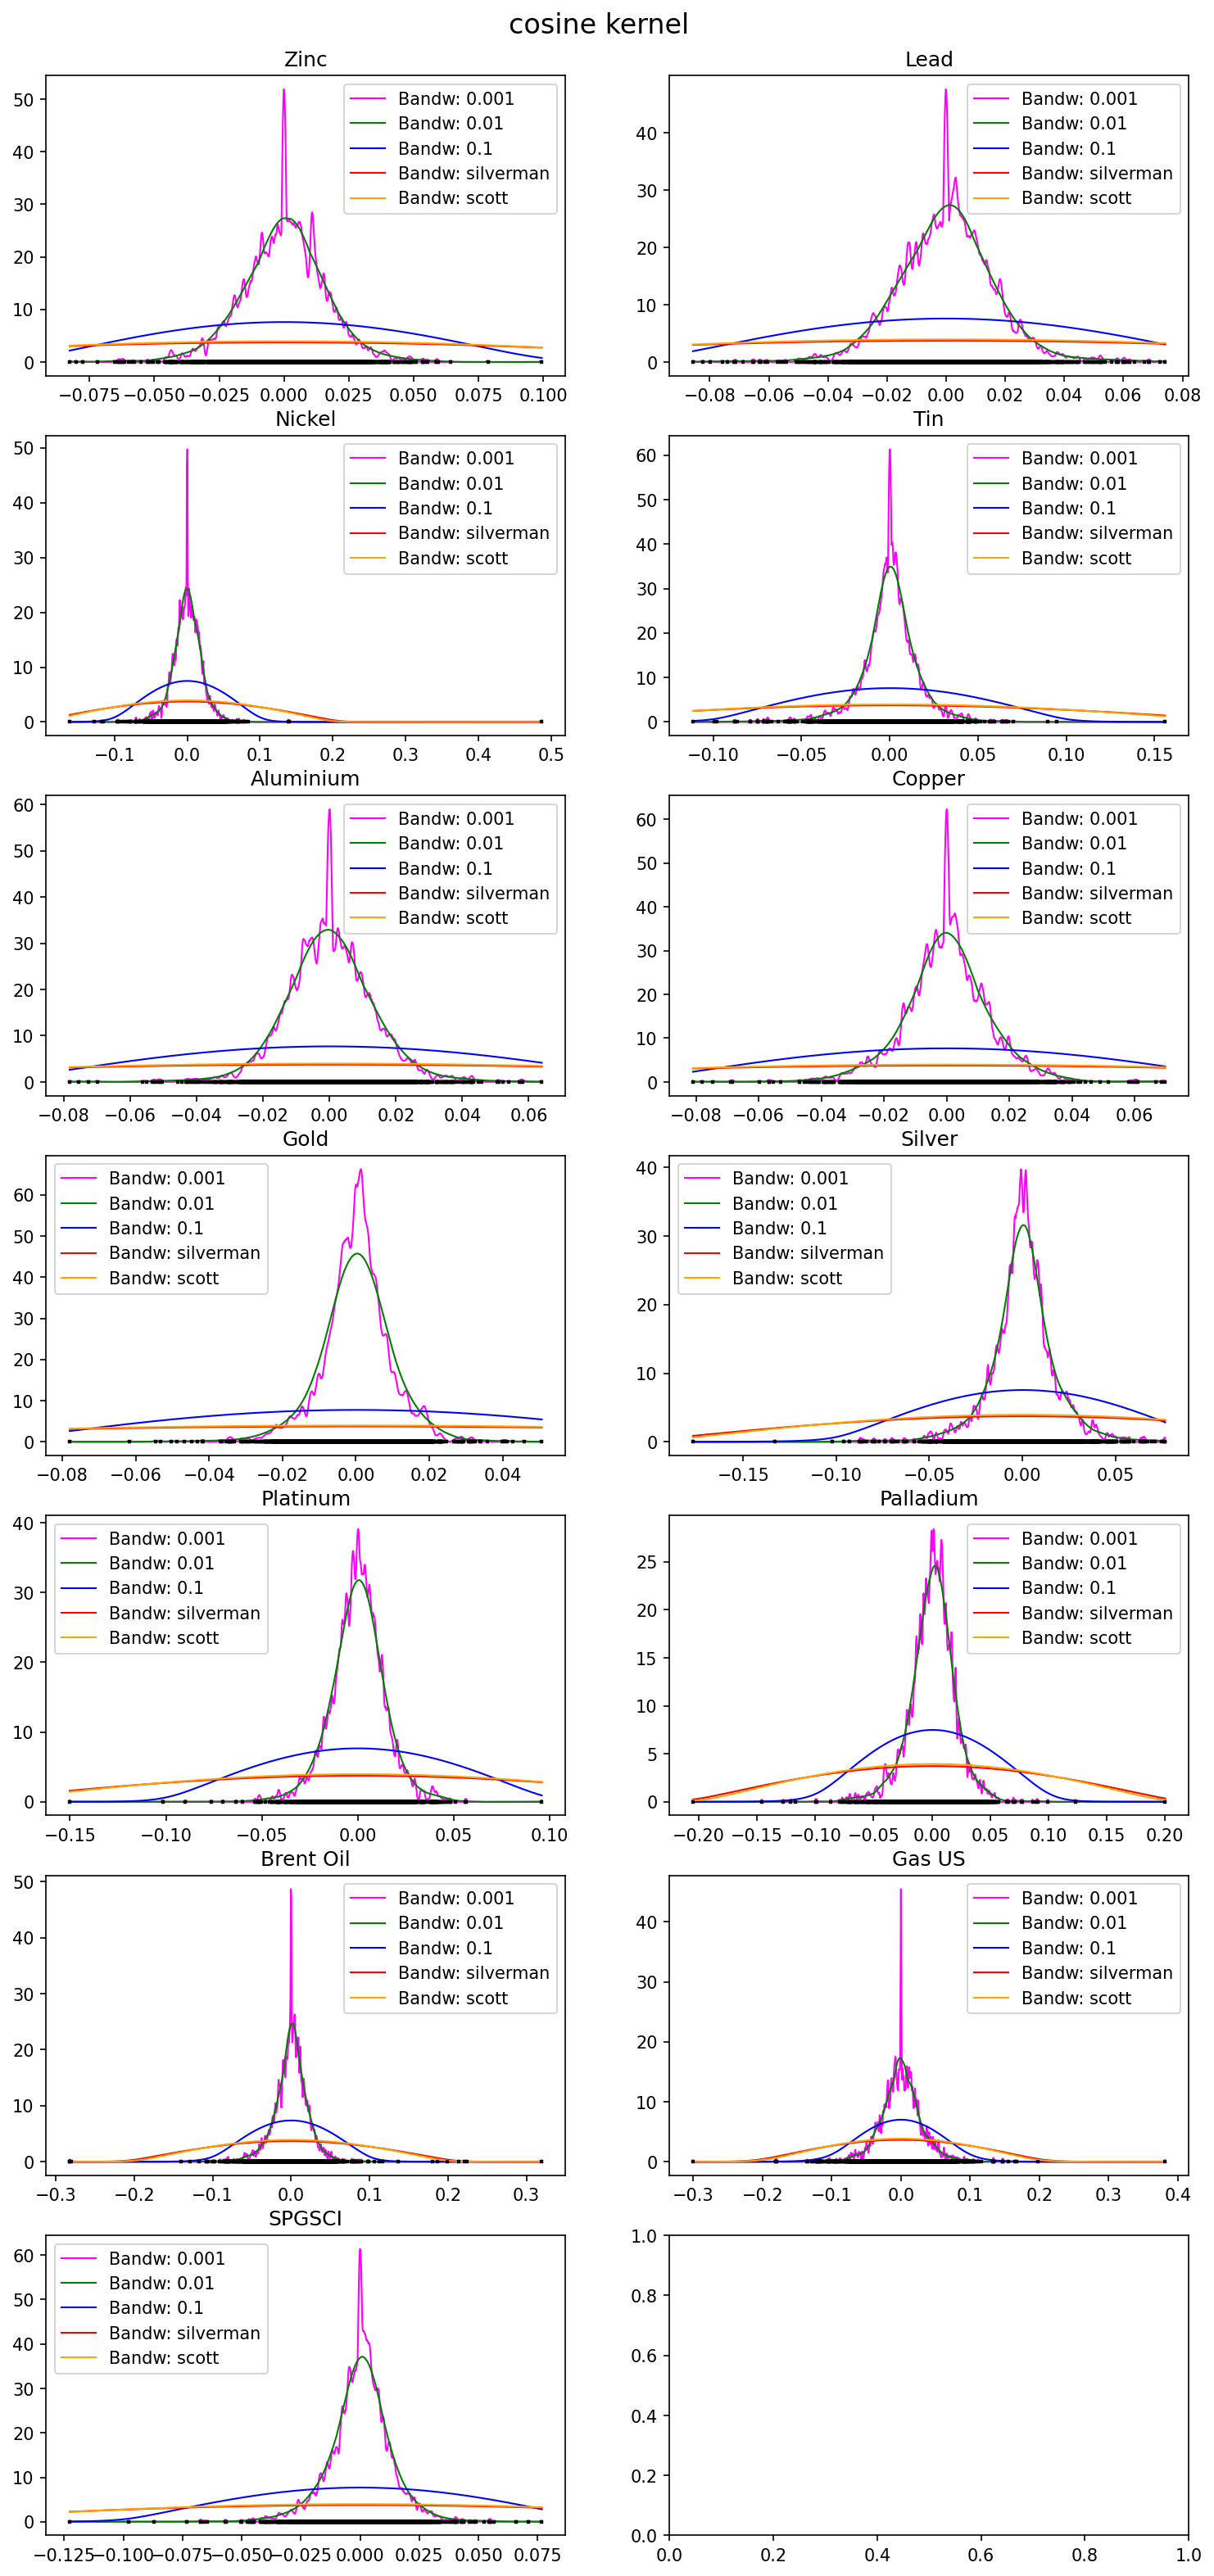

In [13]:
KERNEL = 'cosine'
BANDWITH = [0.001, 0.01, 0.1, 'silverman', 'scott']
COLOR = ['magenta', 'green', 'blue', 'red', 'orange']

fig, axs = plt.subplots(7, 2)
fig.set_figheight(26)
fig.set_figwidth(12)
fig.set_dpi(150)
fig.suptitle(f'{KERNEL} kernel', x=0.5, y=0.90, fontsize=16)
for var in X.columns:
    # KernelDensity requires 2D array, so need to reshape
    dist = X[var].to_numpy().reshape(-1, 1)

    # x-value range for plotting
    x_range = np.linspace(dist.min(), dist.max(), num=1000)

    for bandwidth, color in zip(BANDWITH, COLOR):
        # fitting KDE
        kde = KernelDensity(kernel=KERNEL, bandwidth=bandwidth).fit(dist)
        # compute the log-likelihood of each sample
        log_density = kde.score_samples(x_range.reshape(-1,1))

        # draw KDE curves
        row, col = var_location_dict[var][0], var_location_dict[var][1]
        axs[row, col].set_title(var)
        axs[row, col].plot(
            x_range, np.exp(log_density), color=color, linewidth=1, label=f'Bandw: {bandwidth}')
        axs[row, col].legend()
        axs[row, col].plot(dist, np.zeros_like(dist) , 's', 
        markersize=1, color='black')
        # axs[row, col].set_xlabel('$x$', fontsize=8)
        # axs[row, col].set_ylabel('$f(x)$', fontsize=12, rotation='horizontal', labelpad=8)
plt.show()